# Projeto 1

## Componentes

- Raphael Ramos
- Ernane Ferreira

## Dataset

Usamos um dos datasets das Requisições de Materiais no grupo de Materiais, dos Dados Abertos da UFRN. Abaixo uma descrição dele

In [201]:
# Importa a biblioteca pandas com o alias 'pd'
import pandas as pd

# Lê um arquivo CSV como delimitador ;
rm = pd.read_csv('data/all_data.csv', delimiter=',')

# Exibe as primeiras linhas do DataFrame 'rm' para visualizar os dados
rm['valor'][15]

'R$             4,60'

## Contexto

Quando uma unidade precisa de algum material, ela abre uma requisição para o almoxarifado. Nessa requisição, deve ter o preço estimado desse material e a unidade que vai custear esse material. Assim, o almoxarifado pode aprová-la e dar início a ordem de compra.

## Ideia

Neste dataset, queremos que, dada uma requisição, prever ele vai ser negada ou autorizada pelo almoxarifado. Além disso, investigar qual perfil das requisições que têm mais chances de serem aprovadas.

## Preprocessamento

Como esse dataset possui registros de devolução e requisições que envolvem serviços, vamos considerar apenas as requisições de material da instituição

In [202]:
# Filtre apenas as requisicoes de materiais
df = rm[rm['tipo_requisicao'] == 'REQUISIÇÃO DE MATERIAL']

Algumas colunas em nada agregam ao nosso objetivo, portanto vamos retirá-las

In [203]:
# Retirar colunas
df = df.drop([
    'numero',
    'ano',
    'requisicao',
    'data',
    'observacoes',
    'grupo_material',
    'tipo_requisicao',
    'unidade_custo',
    'id_unidade_custo',
    'id_unidade_requisitante'
], axis=1)

A coluna status é multivalorada, mas apenas nos importa saber se a requisição foi negada ou não.

In [204]:
# Filtrar apenas requisições negadas e as que contem status posteriores a AUTORIZADA
df = df[df['status'].isin(['NEGADA', 'AUTORIZADA', 'A_EMPENHAR', 'LIQUIDADA', 'EM_LIQUIDACAO', 'COMPRA', 'FINALIZADA'])]

# Substituir 'NEGADA' por 1 e outros valores por 0 na coluna 'status'
df['status'] = df['status'].apply(lambda x: 1 if x == 'NEGADA' else 0)

Vamos nos deter apenas as unidades requisitantes administrativas dos departamentos da UFRN

In [205]:
# Filtrar unidades requisitantes por tipo
df = df[(
    df['unidade_requisitante'].str.startswith('ADMINISTRAÇÃO') |
    df['unidade_requisitante'].str.startswith('DIRETORIA') |
    df['unidade_requisitante'].str.startswith('SECRETARIA') |
    df['unidade_requisitante'].str.startswith('DEPARTAMENTO') |
    df['unidade_requisitante'].str.startswith('COORDENAÇÃO') |
    df['unidade_requisitante'].str.startswith('ALMOXARIFADO') 
)]

# Função para realizar a substituição
def categorize_request_unit(valor):
    if valor.startswith("ADMINISTRAÇÃO"):
        return 0
    elif valor.startswith("DIRETORIA"):
        return 1
    elif valor.startswith("SECRETARIA"):
        return 2
    elif valor.startswith("DEPARTAMENTO"):
        return 3
    elif valor.startswith("COORDENAÇÃO"):
        return 4
    elif valor.startswith("ALMOXARIFADO"):
        return 5
    else:
        # Se nenhuma das condições for atendida, mantenha o valor original
        return valor  

# Aplicar a função à coluna "unidade_requisitante" e criar uma nova coluna com os valores substituídos
df['unidade_requisitante'] = df['unidade_requisitante'].apply(categorize_request_unit)


As colunas convenio e almoxarifado são interessantes, mas são categóricas. Portanto, precisão ser tratadas. Abaixo uma função que facilita esse trabalho

In [206]:
from sklearn.preprocessing import LabelEncoder

def categorize(dataframe, column):
    """
    Recebe um dataframe e a coluna com os dados categóricos que se quer rotular

    Args:
        dataframe (object DataFrame)
        column (string)
    """
    # Identificar categorias de column
    data = {category for category in set(dataframe[column])} 
    
    # Traduzir cada categoria para numeros
    label_encoder = LabelEncoder()
    
    # Atualiza no dataframe
    dataframe[column] = label_encoder.fit_transform(dataframe[column])
    
    # Obtenha as categorias originais e seus rótulos numéricos
    categories = label_encoder.classes_
    labels = label_encoder.transform(categories)

    # Visualizar mapeamento
    display(pd.DataFrame({'Categoria':categories, 'Rótulo Numérico': labels}))

In [207]:
categorize(df, 'convenio')

,Categoria,Rótulo Numérico
0,False,0
1,True,1


In [208]:
# Categorize
categorize(df, 'almoxarifado')

,Categoria,Rótulo Numérico
0,ALMOXARIFADO - CB,0
1,ALMOXARIFADO - CCET,1
2,ALMOXARIFADO - CCHLA,2
3,ALMOXARIFADO - CCHLA - PORTARIA 097/2014,3
4,ALMOXARIFADO - CCS,4
5,ALMOXARIFADO - CCSA,5
6,ALMOXARIFADO - CERES,6
7,ALMOXARIFADO - CT,7
8,ALMOXARIFADO - FACISA,8
9,ALMOXARIFADO - RESTAURANTE UNIVERSITÁRIO,9


A coluna `valor` precisa ser transformada em valores decimais

In [209]:
import re

rgx_remove_trash = r'R\$|\s'
rgx_only_last_point = r'\.(?=[^.]*\.)'

df.loc[:,'valor'] = df['valor'].apply(lambda value: re.sub(rgx_only_last_point, '', re.sub(rgx_remove_trash, '', value).replace(',', '.')))
df.loc[:,'valor'] = df['valor'].astype(float)

Abaixo está o dataset após as remoções e categorização das colunas que possuem dados não contínuos

In [210]:
df

,unidade_requisitante,convenio,status,almoxarifado,valor
4,1,0,0,10,86.56
5,1,0,0,10,16.38
7,1,0,0,10,71.64
8,1,0,0,10,18.48
15,1,0,0,10,4.6
...,...,...,...,...,...
623787,5,0,0,10,67.85
623788,5,0,0,10,67.85
623791,5,0,0,10,104.7
623792,5,0,0,10,104.7


Observe que os valores (em reais) das requisições são muito discrepantes em relação as numerações das categorias que fizemos. Podemos ter uma ideia dessa discrepância ao visualizar um boxplot de cada coluna

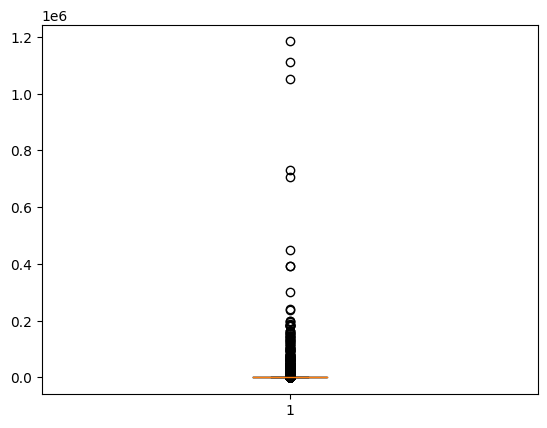

In [211]:
import matplotlib.pyplot as plt

plt.boxplot(df['valor'])
plt.show()

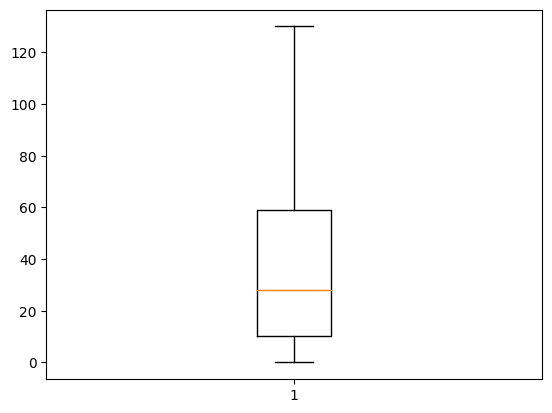

In [212]:
# Remover valores outliers
df = df.loc[df['valor'] < 130]
plt.boxplot(df['valor'])
plt.show()

Verificar linhas que possuem valores NaN

In [213]:
df.isna().sum()

unidade_requisitante    0
convenio                0
status                  0
almoxarifado            0
valor                   0
dtype: int64

Abaixo está o dataset apos o preprocessamento

In [214]:
df

,unidade_requisitante,convenio,status,almoxarifado,valor
4,1,0,0,10,86.56
5,1,0,0,10,16.38
7,1,0,0,10,71.64
8,1,0,0,10,18.48
15,1,0,0,10,4.6
...,...,...,...,...,...
623784,3,0,0,2,3.49
623787,5,0,0,10,67.85
623788,5,0,0,10,67.85
623791,5,0,0,10,104.7
